In [3]:
#this is just to check compatible version of installed libraries:

import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns

print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

NumPy version: 1.26.4
Pandas version: 2.2.2
Matplotlib version: 3.8.4
Seaborn version: 0.13.2


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle
from wordcloud import WordCloud

In [5]:
# Download required NLTK datasets
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\patel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\patel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\patel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
# Load the dataset
df = pd.read_csv('swiggydataset.csv')
print(df.head())
print(df.info())

              date  favorite_count  followers_count  friends_count  \
0  7/18/2019 22:47               0               82            219   
1  7/18/2019 22:43               0              102            129   
2  7/18/2019 22:37               0              102            129   
3  7/18/2019 22:35               0               13             16   
4  7/18/2019 22:25               0              102            129   

                                           full_text  retweet_count retweeted  \
0  @Mahi_2510 @swiggy_in The ultimate answer will...              0     False   
1                            @SwiggyCares I hope so.              0     False   
2  @SwiggyCares I think you have the order detail...              0     False   
3  @swiggy_in People are complaining here also, i...              0     False   
4  @SwiggyCares Do you even know the meaning of y...              0     False   

     screen_name tweet_id                     user_id  
0     syamantak1        1           

In [9]:
# Remove duplicates
df.drop_duplicates(inplace=True)

In [11]:
# Define stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [13]:
# Define a function to clean text
def preprocess_text(text):
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenization
    words = nltk.word_tokenize(text.lower())
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

In [17]:
# Apply preprocessing to the text column
df['cleaned_text'] = df['full_text'].apply(preprocess_text)

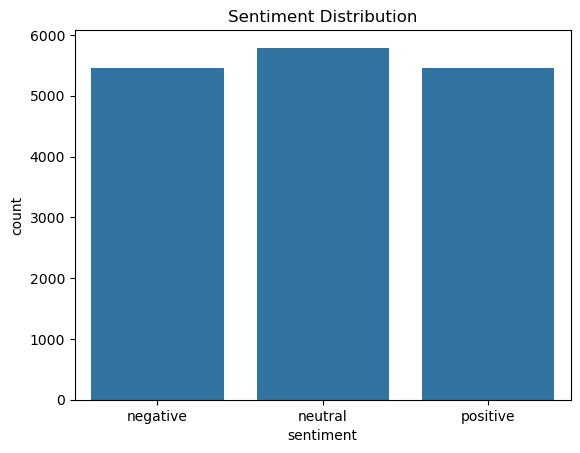

In [99]:
from textblob import TextBlob

# Function to classify sentiment using TextBlob
def get_sentiment(text):
    analysis = TextBlob(text)
    # Sentiment polarity ranges from -1 (negative) to 1 (positive)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply the sentiment function to the 'full_text' column
df['sentiment'] = df['full_text'].apply(get_sentiment)

# Plot sentiment distribution
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()

In [27]:
print(df.columns)  # Check the column names to find the sentiment column

Index(['date', 'favorite_count', 'followers_count', 'friends_count',
       'full_text', 'retweet_count', 'retweeted', 'screen_name', 'tweet_id',
       'user_id', 'cleaned_text', 'sentiment'],
      dtype='object')


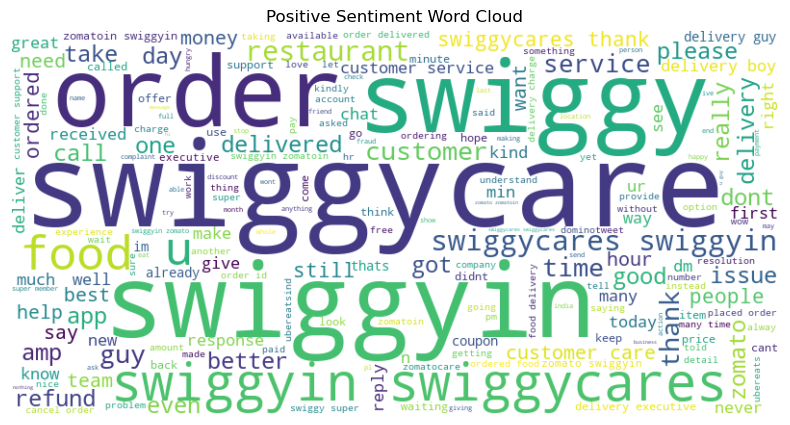

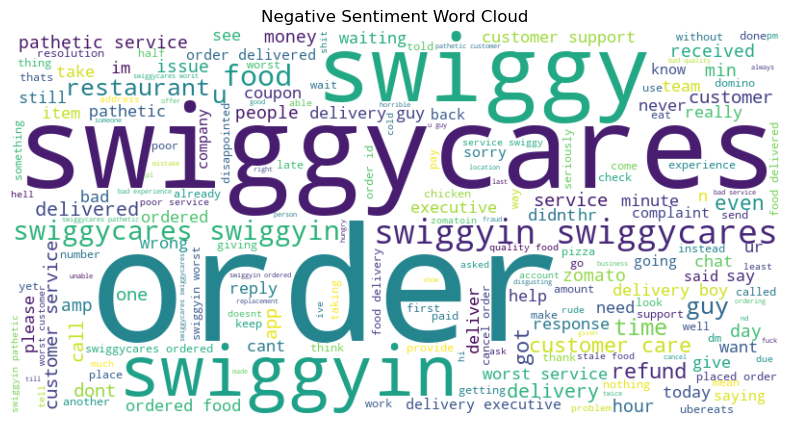

In [31]:
# Word Cloud for positive and negative sentiment
def plot_wordcloud(sentiment, title):
    text = ' '.join(df[df['sentiment'] == sentiment]['cleaned_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_wordcloud('positive', 'Positive Sentiment Word Cloud')
plot_wordcloud('negative', 'Negative Sentiment Word Cloud')

In [35]:
# Using TF-IDF for vectorization
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_text']).toarray()
y = df['sentiment']

In [37]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Model training
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [41]:
# Evaluation
y_pred = model.predict(X_test)

In [43]:
# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 82.05%


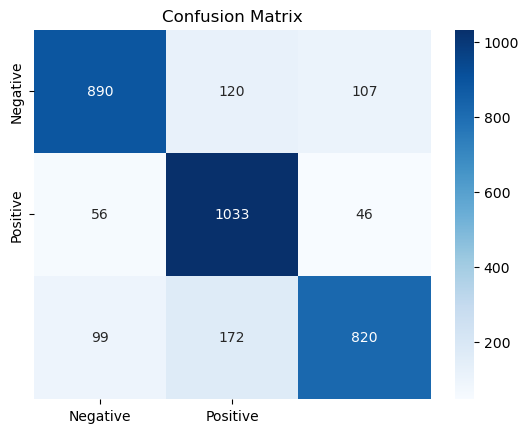

In [45]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.show()

In [47]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.85      0.80      0.82      1117
     neutral       0.78      0.91      0.84      1135
    positive       0.84      0.75      0.79      1091

    accuracy                           0.82      3343
   macro avg       0.82      0.82      0.82      3343
weighted avg       0.82      0.82      0.82      3343



In [49]:
# Save the model and vectorizer
with open('sentiment_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

with open('tfidf_vectorizer.pkl', 'wb') as vec_file:
    pickle.dump(tfidf, vec_file)

In [51]:
# Define a function for prediction
def predict_sentiment(text):
    # Preprocess and transform input text
    cleaned_text = preprocess_text(text)
    transformed_text = tfidf.transform([cleaned_text])
    # Predict
    prediction = model.predict(transformed_text)
    return prediction[0]

In [95]:
# Example prediction
print(predict_sentiment("scrumptious taste"))

positive


#### Here above, I took the Swiggy dataset to investigate the sentiment..

#### But to analyze manually, I also created another project which is uploaded with the same project. In this we do not want to load the dataset, just enter the statement to verify the actual sentiment.

### END: THANK YOU